# ARIMA model 

- Temperature Dataset

### Step 1: Importing neccesary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Step 2: Load the dataset

In [2]:
# Load the dataset
data = pd.read_csv('../ml/dataset/temperature-1.csv')
data.head()

,Unnamed: 0,Datetime,Hourly_Temp
0,0,04-01-2022 00:00,20.867
1,1,04-01-2022 01:00,21.000
2,2,04-01-2022 02:00,20.867
3,3,04-01-2022 03:00,20.650
4,4,04-01-2022 04:00,20.400


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Datetime     7056 non-null   object 
 2   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.5+ KB


### Step 3: Data Preprocessing

In [4]:
# Convert the 'Datetime' column to a datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Set the 'Datetime' column as the DataFrame index
data.set_index('Datetime', inplace=True)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7056 entries, 2022-01-04 00:00:00 to 2022-10-24 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 165.4 KB


### Step 4: Data Visualization

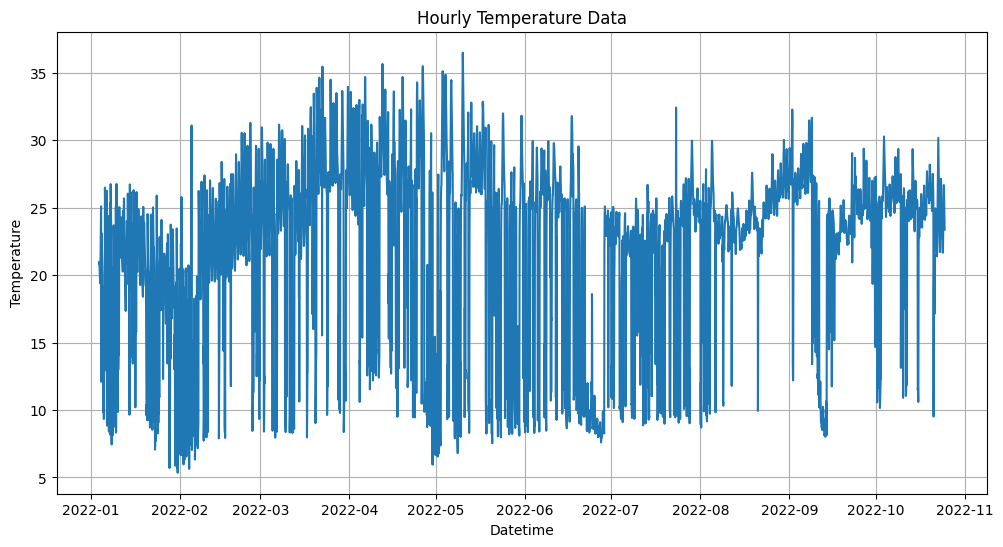

In [6]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'])
plt.title('Hourly Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()


### Step 5: Check Stationarity

In [7]:
# Define a function to check stationarity and perform differencing
def test_stationarity(timeseries):
    # Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    return dfoutput

# Check stationarity
result = test_stationarity(data['Hourly_Temp'])
print("Augmented Dickey-Fuller Test:")
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                -9.396891e+00
p-value                        6.338903e-16
#Lags Used                     2.500000e+01
Number of Observations Used    7.030000e+03
Critical Value (1%)           -3.431281e+00
Critical Value (5%)           -2.861951e+00
Critical Value (10%)          -2.566989e+00
dtype: float64


### Step 6: Perform Differencing

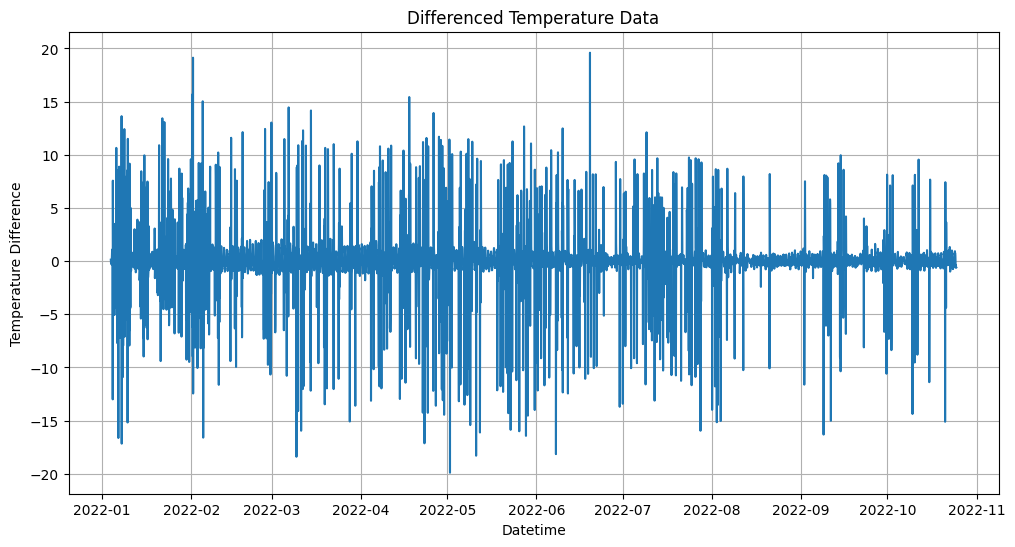

In [9]:
# Differencing to make the series stationary
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data.dropna(inplace=True)

# Plot differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Differenced Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()

### Step 7: Check Stationarity of Differenced Data

In [10]:
# Check stationarity of differenced data
result = test_stationarity(data['Temp_Diff'])
print("Augmented Dickey-Fuller Test on Differenced Data:")
print(result)

Augmented Dickey-Fuller Test on Differenced Data:
Test Statistic                  -20.546080
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7019.000000
Critical Value (1%)              -3.431282
Critical Value (5%)              -2.861952
Critical Value (10%)             -2.566989
dtype: float64


### Step 8: Fit SARIMA Model

In [11]:
# Fit SARIMA model
model = SARIMAX(data['Hourly_Temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
results = model.fit(disp=True)

### Step 9: Forecast Future Values

In [9]:
# Forecast future values
forecast_steps = 24  # Adjust this as needed
forecast = results.get_forecast(steps=forecast_steps)


### Step 10: Create Date Range for Forecasting

In [10]:
# Create a date range for forecasting
date_range = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='H')

### Step 11: Get Forecasted Values and Confidence Intervals

In [11]:
# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

### Step 12: Create a Forecast DataFrame

In [12]:
# Create a forecast DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast_values, 'Lower_CI': forecast_conf_int.iloc[:, 0], 'Upper_CI': forecast_conf_int.iloc[:, 1]}, index=date_range[1:])

### Step 13: Plot the Original Data and the Forecast

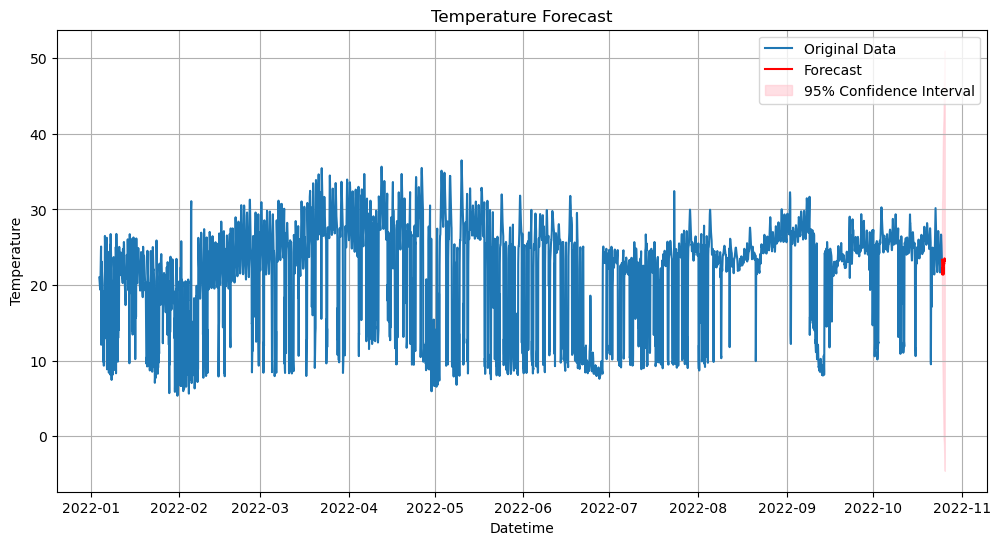

In [13]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'], label='Original Data')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('Temperature Forecast')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()